In [14]:
import torch
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rate = 4/7
EsdB_list = torch.arange(-2, 10, 0.5)
snr_list = 10.0**(EsdB_list/10.0)
EbNo_list = snr_list/rate/2
EbNodB_list = 10*np.log10(EbNo_list)

In [17]:
def i2b(integer, length=4):
    return torch.tensor(list(map(lambda x : [int(z) for z in format(x, '0{}b'.format(length))], integer)))

def encode(U, G):
    return torch.fmod(torch.mm(U, G), 2).to(device)

def mod_bpsk(C):
    X = -(2.0*C-1.0)
    return X

def awgn(X, SNR):
    Z = (torch.randn((X.shape[0], X.shape[1]))/np.sqrt(SNR)).to(device)
    Y = X + Z
    return Y

def decode_ml(Y, CB):
    indx = torch.argmin((torch.abs(Y.unsqueeze(1) - CB)**2).sum(axis=2), dim=1)
    U_hat = CB[indx]
    return U_hat

def decode_hard(Y):
    Y = (Y > 0).type(torch.float)
    Y[Y == 0] = -1.0
    return Y

In [18]:
G = torch.tensor([[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0],
                  [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0],
                  [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0],
                  [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]])

H = torch.tensor([[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0],
                  [1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0],
                  [0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0]])

i = torch.arange(0,16)
I = i2b(i, 4).type(torch.float)
CB = mod_bpsk(encode(I, G))


In [19]:
I, CB = I.to(device), CB.to(device)
G, H = G.to(device), H.to(device)



In [20]:
u = torch.randint(0, 16, (1000000,))
U = i2b(u).type(torch.float)
U = U.to(device)

In [21]:
class Sum_p():
    def __init__(self, Parity_check_matrix, U, SNR):
        self.U = U
        self.pcm = Parity_check_matrix
        self.num_F = Parity_check_matrix.shape[0]
        self.num_X = Parity_check_matrix.shape[1]
        self.Xlist = [Node_X(i, U[:,i], Parity_check_matrix[:,i], SNR) for i in range(self.num_X)]
        self.Flist = [Node_func(Parity_check_matrix[i], U) for i in range(self.num_F)]

       
    def Iter(self, num):
        # 간선이 있으면 0.5 없으면 1
        tp = (torch.empty_like(self.pcm).copy_(self.pcm).unsqueeze(2)/2).unsqueeze(2).to(device)
        f2x = torch.ones(self.num_F, self.num_X, self.U.shape[0], 2).to(device)-tp
        # init
        x2f = torch.empty((self.num_X, self.num_F, self.U.shape[0], 2)).to(device)
        U_hat = torch.empty((self.U.shape[0], self.num_X)).to(device)
            
        # 업데이트
        for i in range(num):
            for n, x in enumerate(self.Xlist):
                x2f[n] = x.update_x2f(f2x[:, n, :], i) 
            for n, f in enumerate(self.Flist):
                f2x[n] = f.update_f2x(x2f[:, n, :])
        # U_hat
        for n, x in enumerate(self.Xlist):
            U_hat[:, n] = x.est_U(f2x[:, n, :])
            
        return U_hat
    
    
##############
# Node_func:
#    init :
#          x_index : 연결된 x노드의 index
#          index : 연결된 x노드에서 사용 가능한 조합의 index
#          f2x : 반환값 지정
#
#    get_index_table :
#        간선으로 연결된 x노드의 개수를 파악하여 모든 노드의 조합 중 유효한 조합의 index를 저장 (Xc 에 해당)
#        
#    update_f2x : <return 3 x 7 x n x 2>
#        연결된 x노드 각각의 확률값을 계산 유효한 조합 index를 통해 접근
#        
#        
#
##############

class Node_func():
    def __init__(self, vec, U):
        self.X_index = torch.where(vec == 1)[0]
        self.index = self.get_index_table()
        self.f2x = torch.ones((vec.shape[0], U.shape[0], 2)).to(device)
        
    def get_index_table(self):
        xs = torch.zeros((self.X_index.shape[0], 2), dtype=int).to(device)
        xs[:, 1] = 1
        temp = torch.tensor(list(product(*xs))).to(device)
        index_table = temp[torch.fmod(temp.sum(dim=1), 2) == 0]
        return index_table
    
    
    def update_f2x(self, X):
        m_x2f = torch.ones(self.index.shape[0], X.shape[1], 1).to(device)
        for n, i in enumerate(self.index):
            temp = 1
            for k, j in enumerate(i):
                temp *= X[self.X_index[k], :, j]
            m_x2f[n] = temp.reshape(X.shape[1], 1)
            
        for n, i in enumerate(self.X_index):
            for b in [0, 1]:
                self.f2x[i, :, b] = m_x2f[self.index[:, n] == b].sum(dim=0).squeeze()/X[i, :, b]
        return torch.sigmoid(self.f2x) ###################################################################
        

##############
# Node_X:
#    init :
#          index : x노드의 index (사용 안함)
#          mask : f노드와 연결되지 않은 m_x2f값은 1로 지정하기위해 생성 ( 곱연산의 편리성을 위함)
#          xi :  1 -> -1 // 0 -> 1
#          p : nan값을 피하기 위해 tanh를 씌운 값을 사용함 ***************************
#
#    get_p :
#        p값 계산
#        
#    update_x2f : <return 7 x 3 x n x 2>
#        p값을 사용하지 않고 m_x2f계산.
#        각 값을 모두 곱하고 자신의 자리에서 따로 나눔
#        
#    est_x2f : 
#        p값을 사용하고 계산
#
#    est_U :
#        모든 f에 대한 값과 p값을 사용하여 U_hat 계산
#
#    pd_mask :
#        m_x2f값 계산중, 간선이 없는 노드와의 연결을 1로 처리
##############

class Node_X():
    def __init__(self, i, U, pcm, SNR):
        self.index = i
        self.mask = torch.ones(pcm.shape[0], U.shape[0], 2).to(device)*pcm.reshape(-1, 1, 1)
        self.xi = torch.tensor([1, -1]).to(device) 
        self.p = self.get_p(U, SNR).to(device)
    
    def get_p(self, U, SNR):
        u = U.reshape(-1, 1)
        p = torch.exp(torch.sigmoid(-1*((torch.abs(u-self.xi)**2)/2)*SNR))######################################
        return p
    
    def update_x2f(self, F, i):
        if i == 0:
            p = self.p
        else:
            p = 1
        f = F.squeeze().to(device)
        f = f.prod(dim=0).unsqueeze(0)/f * p
        return self.pd_mask(f)
    
    def est_U(self, F):
        f = F.detach().to(device)
        f = f.prod(dim=0).unsqueeze(0) * self.p 
        return self.xi[torch.argmax(f, dim = 2)]
        
    def pd_mask(self, F):
        return (F -1) * self.mask +1

In [22]:
db = []
ber = []

for SNR in tqdm(snr_list):
    print('\nSNR :', SNR)
    C = encode(U, G).to(device)
    X = mod_bpsk(C).to(device)    
    Y = awgn(X, SNR).to(device)
    Sum = Sum_p(H, Y, SNR)
    
    U_hat = Sum.Iter(10)
    er = (X != U_hat).sum()/(U_hat.shape[0]*U_hat.shape[1])
    ber.append(er.detach().cpu().numpy())


  0%|          | 0/24 [00:00<?, ?it/s]


SNR : tensor(0.6310)

SNR : tensor(0.7079)

SNR : tensor(0.7943)

SNR : tensor(0.8913)

SNR : tensor(1.)

SNR : tensor(1.1220)

SNR : tensor(1.2589)

SNR : tensor(1.4125)

SNR : tensor(1.5849)

SNR : tensor(1.7783)

SNR : tensor(1.9953)

SNR : tensor(2.2387)

SNR : tensor(2.5119)

SNR : tensor(2.8184)

SNR : tensor(3.1623)

SNR : tensor(3.5481)

SNR : tensor(3.9811)

SNR : tensor(4.4668)

SNR : tensor(5.0119)

SNR : tensor(5.6234)

SNR : tensor(6.3096)

SNR : tensor(7.0795)

SNR : tensor(7.9433)

SNR : tensor(8.9125)


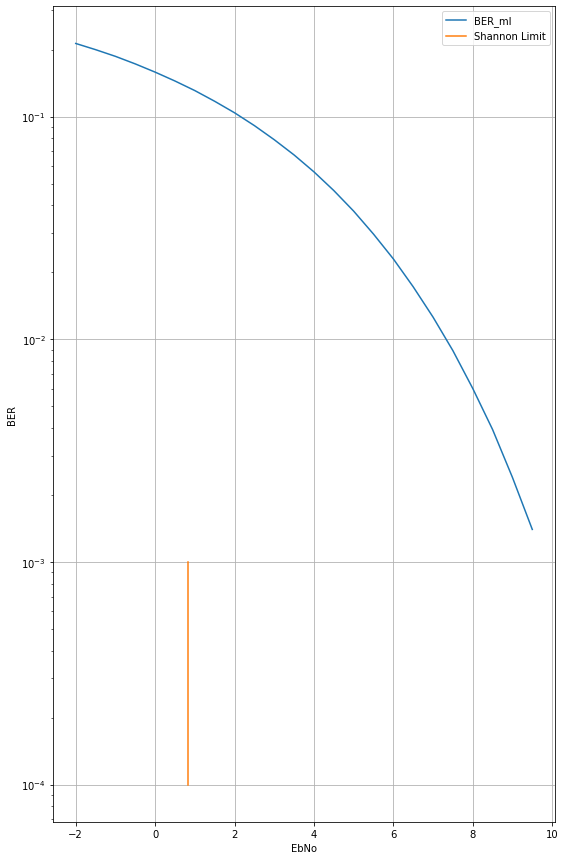

In [23]:
shannon_lim = 10.0*np.log10(2.0**(2*rate)-1)
norm_shannon_lim = 10.0*np.log10((2.0**(2*rate)-1)*rate/2)

plt.figure(figsize=(9,15), facecolor='white')
plt.semilogy(EsdB_list, ber)
plt.semilogy([shannon_lim, shannon_lim], [1e-4,1e-3])
plt.legend(['BER_ml','Shannon Limit'])
plt.xlabel('EbNo')
plt.ylabel('BER')
plt.grid()
plt.savefig('BER_ml_for')

# clip 과정을 임의로 sigmoid를 사용했기 때문에 오차 발생